# 《人工智能基础与智能船舶》课程论文代码

以下是论文的代码，并附有相关描述。

数据集：凯斯西储大学、官网：http://csegroups.case.edu/bearingdatacenter/home

## 0 部分环境参数设定

In [ ]:
'''
根据个人搭建的环境，进行调整即可。
考虑到实验室还有传统的软件开发需求，为避免环境变量混乱。故保持系统原本设定，不同项目进行初始微调即可。
参数调整记录如下：
'''
#环境参数调整-----------------------------------------

#因安装了Python2，Python3，安装包时候又使用了pip、conda，暂时没有将包整理，这里进行一次路径引用。
import sys
sys.path.append("/Users/changxingshan/anaconda3/lib/")
sys.path.append("/Users/changxingshan/anaconda3/lib/python3.7/site-packages/")
#----------------------------------
#Mac系统matplotlib等 绘图使用中文
from matplotlib.font_manager import FontManager, FontProperties
def getChineseFont():
    return FontProperties(fname='/System/Library/Fonts/PingFang.ttc')
#调用方法：
#plot.title("汉语", fontproperties=getChineseFont())
#----------------------------------

#环境参数调整-----------------------------------------

## 1 基础的CNN模型构建

根据卷积神经网络的基本结构，构建一个基础的卷积神经网络，仅作为CNN模型试验，这是后续模型构建基础。
结构参数如下：
### 1  卷积层1：
    卷积核大小：20*1
    步长：8*1
    卷积核数量：32
### 2 池化层1
    卷积核大小：4*1
    步长：4*1
    卷积核数量：32
### 3 全链接
### 4 Softmax函数
最后是一个全连接输出层，激活函数为Softmax函数，输出十类轴承故障。

训练样本维度: (7000, 2048, 1)
7000 训练样本个数
验证样本的维度 (2000, 2048, 1)
2000 验证样本个数
测试样本的维度 (1000, 2048, 1)
1000 测试样本个数
Epoch 1/12
55/55 [==============================] - 1s 26ms/step - loss: 1.5721 - accuracy: 0.4874 - val_loss: 1.6861 - val_accuracy: 0.4025
Epoch 2/12
55/55 [==============================] - 1s 23ms/step - loss: 0.3589 - accuracy: 0.9434 - val_loss: 1.8132 - val_accuracy: 0.2505
Epoch 3/12
55/55 [==============================] - 1s 23ms/step - loss: 0.1553 - accuracy: 0.9713 - val_loss: 1.7818 - val_accuracy: 0.3020
Epoch 4/12
55/55 [==============================] - 1s 23ms/step - loss: 0.1056 - accuracy: 0.9811 - val_loss: 1.7728 - val_accuracy: 0.4070
Epoch 5/12
55/55 [==============================] - 1s 23ms/step - loss: 0.0718 - accuracy: 0.9900 - val_loss: 1.4308 - val_accuracy: 0.5145
Epoch 6/12
55/55 [==============================] - 1s 23ms/step - loss: 0.0489 - accuracy: 0.9960 - val_loss: 1.2464 - val_accuracy: 0.5740
Epoch 7/12
55/55 [============================

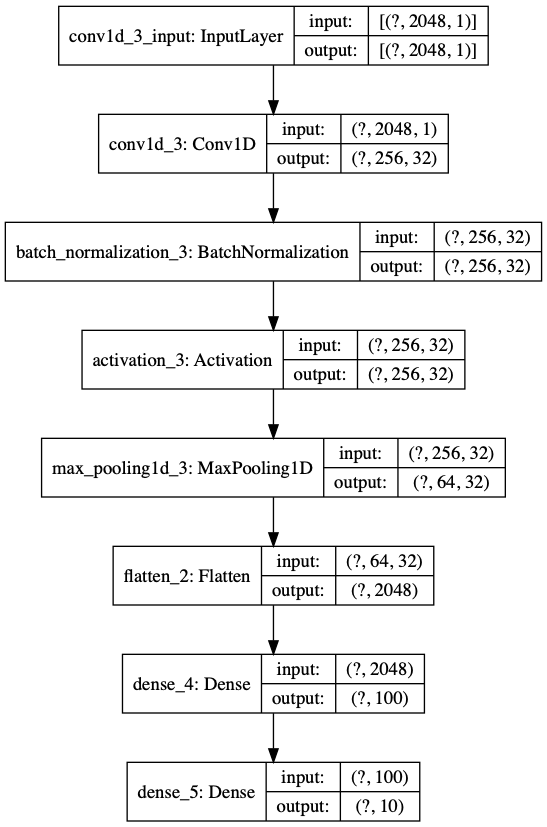

In [3]:
# 最基础的CNN模型实现：
# 基于Keras框架
# 数据预处理程序：preprocess

from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras.models import Sequential
from keras.utils import plot_model
from keras.regularizers import l2
import preprocess
from keras.callbacks import TensorBoard
import numpy as np
# 训练参数
batch_size = 128
epochs = 12
num_classes = 10
length = 2048
BatchNorm = True
number = 1000
normal = True
rate = [0.7,0.2,0.1]
#数据集选择
path = r'data/0HP'
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess.prepro(d_path=path,length=length,
                                                                  number=number,
                                                                  normal=normal,
                                                                  rate=rate,
                                                                  enc=True, enc_step=28)
x_train, x_valid, x_test = x_train[:,:,np.newaxis], x_valid[:,:,np.newaxis], x_test[:,:,np.newaxis]
# 输入数据的维度
input_shape =x_train.shape[1:]
print('训练样本维度:', x_train.shape)
print(x_train.shape[0], '训练样本个数')
print('验证样本的维度', x_valid.shape)
print(x_valid.shape[0], '验证样本个数')
print('测试样本的维度', x_test.shape)
print(x_test.shape[0], '测试样本个数')
model_name = "cnn_1D"
# 实例化一个Sequential
model = Sequential()
#卷积
model.add(Conv1D(filters=32, kernel_size=20, strides=8, padding='same',kernel_regularizer=l2(1e-4), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='valid'))
# 从卷积到全连接需要展平
model.add(Flatten())
# 添加全连接层
model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(1e-4)))
# 增加输出层，共num_classes个单元
model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(1e-4)))
# 编译模型
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
# TensorBoard调用查看一下训练情况
tb_cb = TensorBoard(log_dir='logs/{}'.format(model_name))
# 开始模型训练
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_valid, y_valid), shuffle=True,
          callbacks=[tb_cb])
# 评估模型
score = model.evaluate(x=x_test, y=y_test, verbose=0)
print("测试集上的损失率：", score[0])
print("测试集上的准确率：", score[1])
plot_model(model=model, to_file='images/cnn-1D.png', show_shapes=True)

## 2 一维卷积神经网络的滚动轴承故障诊断 

提出对时域信号进行诊断的一维卷积神经网络，使用提出的卷积神经网络在 CWRU 滚动轴承数据集上进行训练。 

一维卷积神经网络结构参数：
编号  网络层  卷积核大小/步长  卷积核数目  输出大小(宽度× 深度)   零补  
1       卷积 1       20 × 1/8× 1        32       256 × 32                       是  
2       池化 1       4 × 1/4 × 1        32        64 × 32                       否   
3       卷积 2       5 × 1/2 × 1       64        32 × 64                       是   
4       池化 2       2 × 1/2 × 1       64        16 × 64                       否   
5       全连接         500                 1        500 × 1     
6       Softmax       10                 1             10  

训练样本维度: (7000, 2048, 1)
7000 训练样本个数
验证样本的维度 (2000, 2048, 1)
2000 验证样本个数
测试样本的维度 (1000, 2048, 1)
1000 测试样本个数
Epoch 1/20
55/55 [==============================] - 2s 36ms/step - loss: 0.8317 - accuracy: 0.7499 - val_loss: 1.0852 - val_accuracy: 0.6475
Epoch 2/20
55/55 [==============================] - 2s 32ms/step - loss: 0.0771 - accuracy: 0.9931 - val_loss: 2.4803 - val_accuracy: 0.3160
Epoch 3/20
55/55 [==============================] - 2s 33ms/step - loss: 0.0356 - accuracy: 0.9999 - val_loss: 3.9769 - val_accuracy: 0.1180
Epoch 4/20
55/55 [==============================] - 2s 33ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 4.3336 - val_accuracy: 0.1315
Epoch 5/20
55/55 [==============================] - 2s 32ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 3.8459 - val_accuracy: 0.2315
Epoch 6/20
55/55 [==============================] - 2s 32ms/step - loss: 0.0270 - accuracy: 0.9999 - val_loss: 2.7538 - val_accuracy: 0.3955
Epoch 7/20
55/55 [============================

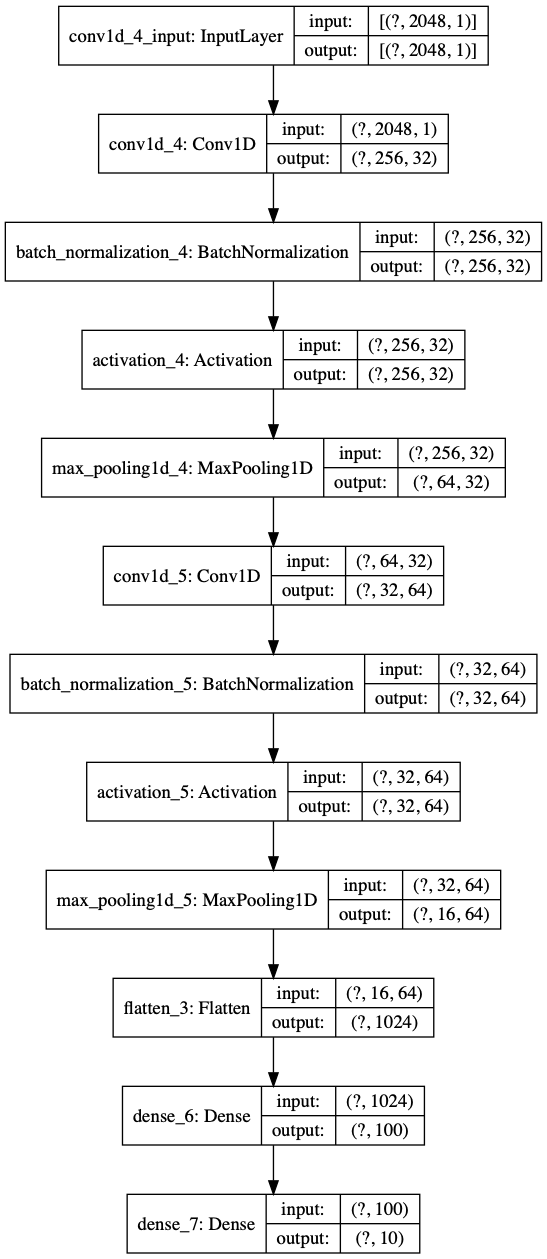

In [4]:
from keras.layers import Conv1D, Dense, Dropout, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras.models import Sequential
from keras.utils import plot_model
from keras.regularizers import l2
import preprocess
from keras.callbacks import TensorBoard
import numpy as np
batch_size = 128
epochs = 20
num_classes = 10
length = 2048
BatchNorm = True
number = 1000
normal = True
rate = [0.7,0.2,0.1]

path = r'data/0HP'
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess.prepro(d_path=path,length=length,
                                                                  number=number,
                                                                  normal=normal,
                                                                  rate=rate,
                                                                  enc=True, enc_step=28)
x_train, x_valid, x_test = x_train[:,:,np.newaxis], x_valid[:,:,np.newaxis], x_test[:,:,np.newaxis]
input_shape =x_train.shape[1:]
print('训练样本维度:', x_train.shape)
print(x_train.shape[0], '训练样本个数')
print('验证样本的维度', x_valid.shape)
print(x_valid.shape[0], '验证样本个数')
print('测试样本的维度', x_test.shape)
print(x_test.shape[0], '测试样本个数')
def wdcnn(filters, kernerl_size, strides, conv_padding, pool_padding,  pool_size, BatchNormal):
    model.add(Conv1D(filters=filters, kernel_size=kernerl_size, strides=strides,
                     padding=conv_padding, kernel_regularizer=l2(1e-4)))
    if BatchNormal:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=pool_size, padding=pool_padding))
    return model

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=20, strides=8, padding='same',kernel_regularizer=l2(1e-4), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))

model = wdcnn(filters=64, kernerl_size=5, strides=2, conv_padding='same',
              pool_padding='valid',  pool_size=2, BatchNormal=BatchNorm)

model.add(Flatten())
model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(1e-4)))
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
tb_cb = TensorBoard(log_dir='logs')
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_valid, y_valid), shuffle=True,
          callbacks=[tb_cb])
score = model.evaluate(x=x_test, y=y_test, verbose=0)
print("测试集上的损失率：", score[0])
print("测试集上的准确率：", score[1])
plot_model(model=model, to_file='images/cnn-1d-HsC.png', show_shapes=True)

## 3 卷积核大小等比下降
卷积核宽度等比减小深度卷积神经网络
Convolution kernel width proportionally reduce the depth convolutional neural network
WPRDCNN

In [9]:
from keras.layers import Conv1D, Dense, Dropout, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras.models import Sequential
from keras.utils import plot_model
from keras.regularizers import l2
import preprocess
from keras.callbacks import TensorBoard
import numpy as np

# 训练参数
batch_size = 128
epochs = 20
num_classes = 10
length = 2048
BatchNorm = True
number = 1000
normal = True 
rate = [0.7,0.2,0.1] 

path = r'data/3HP'
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess.prepro(d_path=path,length=length,
                                                                  number=number,
                                                                  normal=normal,
                                                                  rate=rate,
                                                                  enc=True, enc_step=28)
x_train, x_valid, x_test = x_train[:,:,np.newaxis], x_valid[:,:,np.newaxis], x_test[:,:,np.newaxis]
input_shape =x_train.shape[1:]

print('训练样本维度:', x_train.shape)
print(x_train.shape[0], '训练样本个数')
print('验证样本的维度', x_valid.shape)
print(x_valid.shape[0], '验证样本个数')
print('测试样本的维度', x_test.shape)
print(x_test.shape[0], '测试样本个数')

# 定义卷积层
def wdcnn(filters, kernerl_size, strides, conv_padding, pool_padding,  pool_size, BatchNormal):
    """wdcnn层神经元
    :param filters: 卷积核的数目，整数
    :param kernerl_size: 卷积核的尺寸，整数
    :param strides: 步长，整数
    :param conv_padding: 'same','valid'
    :param pool_padding: 'same','valid'
    :param pool_size: 池化层核尺寸，整数
    :param BatchNormal: 是否Batchnormal，布尔值
    :return: model
    """
    model.add(Conv1D(filters=filters, kernel_size=kernerl_size, strides=strides,
                     padding=conv_padding, kernel_regularizer=l2(1e-4)))
    if BatchNormal:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=pool_size, padding=pool_padding))
    return model

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=64, strides=16, padding='same',kernel_regularizer=l2(1e-4), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model = wdcnn(filters=32, kernerl_size=32, strides=1, conv_padding='same',
              pool_padding='valid',  pool_size=2, BatchNormal=BatchNorm)
model = wdcnn(filters=64, kernerl_size=16, strides=1, conv_padding='same',
              pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
model = wdcnn(filters=64, kernerl_size=8, strides=1, conv_padding='same',
              pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
model = wdcnn(filters=64, kernerl_size=4, strides=1, conv_padding='same',
              pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
# 实验20200702-5 卷积核3*1-->2*1
model = wdcnn(filters=64, kernerl_size=2, strides=1, conv_padding='valid',
              pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
model.add(Flatten())
model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(1e-4)))
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
tb_cb = TensorBoard(log_dir='logs')

def save_to_file_by_add(file_name, contents):
    with open(filename, 'a') as file_object:
        file_object.write(contents)

#20次训练结果进行统计分析-------------------------------------------------Begin
current_number=1  #循环控制
filename = 'ResultOfWPRDCNN.txt'
contents=path
contents="训练所用数据集：{} \n".format(path)
save_to_file_by_add(filename, contents)
import csv
f = open('ResultOfWPRDCNN.csv','a',encoding='utf-8')
csv_writer = csv.writer(f)
csv_writer.writerow([contents,""])
csv_writer.writerow(["测试集上的损失率","测试集上的准确率"])

while current_number <= 20: 
    model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,
              verbose=1, validation_data=(x_valid, y_valid), shuffle=True,
              callbacks=[tb_cb])
    score = model.evaluate(x=x_test, y=y_test, verbose=0)   
    #训练结果数据存储到TXT文件
    contents="第{}次训练结果： \n测试集上的损失率：{} \n测试集上的准确率：{} \n".format(current_number,score[0], score[1])
    save_to_file_by_add(filename, contents)
    #训练结果数据存储到CSV文件
    csv_writer.writerow([score[0], score[1]])
    current_number += 1    
#统计20次训练结果----------------------------------------------------End
f.close()

print("********************Over*************************")

训练样本维度: (7000, 2048, 1)
7000 训练样本个数
验证样本的维度 (2000, 2048, 1)
2000 验证样本个数
测试样本的维度 (1000, 2048, 1)
1000 测试样本个数
Epoch 1/20
55/55 [==============================] - 4s 68ms/step - loss: 0.6466 - accuracy: 0.8311 - val_loss: 1.7681 - val_accuracy: 0.4000
Epoch 2/20
55/55 [==============================] - 4s 67ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 1.3640 - val_accuracy: 0.5590
Epoch 3/20
55/55 [==============================] - 4s 76ms/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.8970 - val_accuracy: 0.6805
Epoch 4/20
55/55 [==============================] - 4s 79ms/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.3504 - val_accuracy: 0.8825
Epoch 5/20
55/55 [==============================] - 4s 78ms/step - loss: 0.0368 - accuracy: 1.0000 - val_loss: 0.0941 - val_accuracy: 0.9925
Epoch 6/20
55/55 [==============================] - 4s 78ms/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 0.9995
Epoch 7/20
55/55 [============================

Epoch 16/20
55/55 [==============================] - 4s 79ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 17/20
55/55 [==============================] - 4s 79ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 18/20
55/55 [==============================] - 4s 77ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 19/20
55/55 [==============================] - 4s 75ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 20/20
55/55 [==============================] - 4s 76ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 1/20
55/55 [==============================] - 4s 73ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 2/20
55/55 [==============================] - 4s 75ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 3/

Epoch 11/20
55/55 [==============================] - 4s 69ms/step - loss: 0.0141 - accuracy: 0.9999 - val_loss: 0.0207 - val_accuracy: 0.9970
Epoch 12/20
55/55 [==============================] - 4s 69ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 13/20
55/55 [==============================] - 4s 69ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 14/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 15/20
55/55 [==============================] - 4s 69ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 16/20
55/55 [==============================] - 4s 69ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 17/20
55/55 [==============================] - 4s 70ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 

Epoch 9/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 10/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 11/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0147 - accuracy: 0.9994 - val_loss: 0.0433 - val_accuracy: 0.9960
Epoch 12/20
55/55 [==============================] - 4s 70ms/step - loss: 0.0129 - accuracy: 0.9999 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 13/20
55/55 [==============================] - 4s 72ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 14/20
55/55 [==============================] - 4s 68ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 15/20
55/55 [==============================] - 4s 67ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 1

Epoch 7/20
55/55 [==============================] - 4s 73ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 8/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 9/20
55/55 [==============================] - 4s 72ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 10/20
55/55 [==============================] - 4s 71ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 11/20
55/55 [==============================] - 4s 70ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 12/20
55/55 [==============================] - 4s 73ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 13/20
55/55 [==============================] - 4s 68ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 14/

## 4 基于LSTM构建轴承故障诊断模型
用LSTM构建

In [4]:
from keras.layers import Dense, Activation, Flatten, LSTM
from keras.models import Sequential
from keras.utils import plot_model
#from keras.regularizers import l2
import preprocess
from keras.callbacks import TensorBoard
import numpy as np
import time

# 训练参数
batch_size = 128
epochs = 12
num_classes = 10
length = 2048
BatchNorm = True 
number = 1000 
normal = True 
rate = [0.7,0.2,0.1] 
date=time.strftime("%Y%m%d", time.localtime())
mark=time.strftime("%Y%m%d_%H%M", time.localtime())

path = r'data/3HP'
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess.prepro(d_path=path,length=length,
                                                                  number=number,
                                                                  normal=normal,
                                                                  rate=rate,
                                                                  enc=True, enc_step=28)
x_train, x_valid, x_test = x_train[:,:,np.newaxis], x_valid[:,:,np.newaxis], x_test[:,:,np.newaxis]
input_shape =x_train.shape[1:]
print('训练样本维度:', x_train.shape)
print(x_train.shape[0], '训练样本个数')
print('验证样本的维度', x_valid.shape)
print(x_valid.shape[0], '验证样本个数')
print('测试样本的维度', x_test.shape)
print(x_test.shape[0], '测试样本个数')
model_name = "lstm_diagnosis-20-{}".format(mark)
model = Sequential()
model.add(LSTM(32, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', return_sequences=True))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))

#model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(1e-4)))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
tb_cb = TensorBoard(log_dir='logs/{}_logs/{}'.format(date, model_name))
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_valid, y_valid), shuffle=True,
          callbacks=[tb_cb])

score = model.evaluate(x=x_test, y=y_test, verbose=0)
print("测试集上的损失率：", score[0])
print("测试集上的准确率：", score[1])
plot_model(model=model, to_file='images/istm-mode.png', show_shapes=True)

print("********************Over*************************")

# 数据集：data/0HP
# 测试集上的损失率： 0.4970026910305023
# 测试集上的准确率： 0.9319999814033508
# 数据集：data/1HP
# 测试集上的损失率： 0.15678782761096954
# 测试集上的准确率： 0.9729999899864197
# 数据集：data/2HP
# 测试集上的损失率： 0.3977309763431549
# 测试集上的准确率： 0.9490000009536743
# 数据集：data/3HP
# 测试集上的损失率： 0.005027007311582565
# 测试集上的准确率： 1.0

训练样本维度: (7000, 2048, 1)
7000 训练样本个数
验证样本的维度 (2000, 2048, 1)
2000 验证样本个数
测试样本的维度 (1000, 2048, 1)
1000 测试样本个数
Epoch 1/12
55/55 [==============================] - 99s 2s/step - loss: 1.0223 - accuracy: 0.6440 - val_loss: 0.2555 - val_accuracy: 0.9405
Epoch 2/12
55/55 [==============================] - 92s 2s/step - loss: 0.1544 - accuracy: 0.9543 - val_loss: 0.1024 - val_accuracy: 0.9835
Epoch 3/12
55/55 [==============================] - 91s 2s/step - loss: 0.0509 - accuracy: 0.9947 - val_loss: 0.0377 - val_accuracy: 0.9945
Epoch 4/12
55/55 [==============================] - 92s 2s/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9990
Epoch 5/12
55/55 [==============================] - 97s 2s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 0.9995
Epoch 6/12
55/55 [==============================] - 92s 2s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 7/12
55/55 [==============================] - 

## 其他
测试不同全连接层数、卷积层数选择最优模型

In [ ]:
# 后续优化
from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras.models import Sequential
from keras.utils import plot_model
from keras.regularizers import l2
import preprocess
from keras.callbacks import TensorBoard
import numpy as np
import time

# 训练参数
batch_size = 128
epochs = 12
num_classes = 10
length = 2048
BatchNorm = True # 是否批量归一化
number = 1000 # 每类样本的数量
normal = True # 是否标准化
rate = [0.7,0.2,0.1] # 测试集验证集划分比例
date=time.strftime("%Y%m%d", time.localtime())

path = r'data/1HP'
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess.prepro(d_path=path,length=length,
                                                                  number=number,
                                                                  normal=normal,
                                                                  rate=rate,
                                                                  enc=True, enc_step=28)

x_train, x_valid, x_test = x_train[:,:,np.newaxis], x_valid[:,:,np.newaxis], x_test[:,:,np.newaxis]

input_shape =x_train.shape[1:]

print('训练样本维度:', x_train.shape)
print(x_train.shape[0], '训练样本个数')
print('验证样本的维度', x_valid.shape)
print(x_valid.shape[0], '验证样本个数')
print('测试样本的维度', x_test.shape)
print(x_test.shape[0], '测试样本个数')

# train multiple models
conv_layers = [1, 2, 3]
layer_sizes = [32, 64, 128]
dense_layers = [0, 1, 2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            mark=time.strftime("%Y%m%d_%H%M", time.localtime())#在模型末尾标注日期时间
            model_name = "{}-conv-{}-filters-{}-dense-{}".format(conv_layer, layer_size, dense_layer, mark)
            tb_cb = TensorBoard(log_dir='logs/{}_logs/{}'.format(date, model_name))
            print(model_name)
            model = Sequential()
         
            model.add(Conv1D(filters=16, kernel_size=64, strides=16, padding='same', kernel_regularizer=l2(1e-4), input_shape=input_shape))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling1D(pool_size=2))

            for l in range(conv_layer-1):
                model.add(Conv1D(layer_size,kernel_size=3, strides=1, padding='same',kernel_regularizer=l2(1e-4), input_shape=input_shape))
                model.add(BatchNormalization())
                model.add(Activation('relu'))
                model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))

            #从卷积到全连接展平
            model.add(Flatten()) 
            
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))

            model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(1e-4)))
            
            #编译模型
            model.compile(loss="categorical_crossentropy",
                         optimizer="adam",
                         metrics=["accuracy"])
            
            #训练模型
            model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,
                      verbose=1, validation_data=(x_valid, y_valid), shuffle=True,
                      callbacks=[tb_cb])
            
            plot_model(model=model, to_file="images/{}-conv-{}-filters-{}-dense.png".format(conv_layer, layer_size, dense_layer), show_shapes=True)

# 评估模型
score = model.evaluate(x=x_test, y=y_test, verbose=0)
print("loss：", score[0])
print("accuracy：", score[1])

训练样本维度: (7000, 2048, 1)
7000 训练样本个数
验证样本的维度 (2000, 2048, 1)
2000 验证样本个数
测试样本的维度 (1000, 2048, 1)
1000 测试样本个数
1-conv-32-filters-0-dense-20200630_1325
Epoch 1/12
55/55 [==============================] - 1s 13ms/step - loss: 1.9249 - accuracy: 0.3279 - val_loss: 1.7928 - val_accuracy: 0.3480
Epoch 2/12
55/55 [==============================] - 1s 12ms/step - loss: 0.7922 - accuracy: 0.7686 - val_loss: 1.5506 - val_accuracy: 0.3555
Epoch 3/12
55/55 [==============================] - 1s 12ms/step - loss: 0.3984 - accuracy: 0.9333 - val_loss: 1.2458 - val_accuracy: 0.4800
Epoch 4/12
55/55 [==============================] - 1s 14ms/step - loss: 0.2395 - accuracy: 0.9724 - val_loss: 0.8515 - val_accuracy: 0.6940
Epoch 5/12
55/55 [==============================] - 1s 14ms/step - loss: 0.1538 - accuracy: 0.9910 - val_loss: 0.5586 - val_accuracy: 0.8135
Epoch 6/12
55/55 [==============================] - 1s 13ms/step - loss: 0.1092 - accuracy: 0.9941 - val_loss: 0.4196 - val_accuracy: 0.8710
Epoch 

Epoch 9/12
55/55 [==============================] - 2s 31ms/step - loss: 0.0154 - accuracy: 0.9994 - val_loss: 0.2394 - val_accuracy: 0.9730
Epoch 10/12
55/55 [==============================] - 2s 32ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.2136 - val_accuracy: 0.9735
Epoch 11/12
55/55 [==============================] - 2s 34ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.2379 - val_accuracy: 0.9730
Epoch 12/12
55/55 [==============================] - 2s 30ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy: 0.9725
3-conv-64-filters-0-dense-20200630_1327
Epoch 1/12
55/55 [==============================] - 2s 36ms/step - loss: 1.0675 - accuracy: 0.6680 - val_loss: 1.2610 - val_accuracy: 0.6980
Epoch 2/12
55/55 [==============================] - 2s 33ms/step - loss: 0.1623 - accuracy: 0.9819 - val_loss: 0.8839 - val_accuracy: 0.6360
Epoch 3/12
55/55 [==============================] - 2s 35ms/step - loss: 0.0728 - accuracy: 0.9861 - val_loss: 